In [ ]:
# !pip install --upgrade pip
# !pip uninstall hazm numpy -y  # حذف نصب‌های قبلی
# !pip install hazm numpy==1.26.4 nltk fasttext-wheel flashtext gensim

In [ ]:
# !pip install plotly dash

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from google.colab import drive
import matplotlib.pyplot as plt
# from hazm import Normalizer, word_tokenize, Stemmer
import plotly.graph_objects as go
import plotly.figure_factory as ff

In [2]:
# اتصال به گوگل درایو
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/digikala_data/cleaned_merged_digikala.csv"

df = pd.read_csv(file_path)
print("\n پیش‌نمایش داده‌ها:")
df.head()

Mounted at /content/drive


/tmp/ipython-input-2683649484.py:5: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)



 پیش‌نمایش داده‌ها:


id_x           title  \
0  53672599  پیشنهاد نمیشود   
1   9897229    بسته بندی بد   
2  38074516        برس ریمل   
3  18628562   خوبه و خوشرنگ   
4  53301258      برس رنگ مو   

                                                body      created_at  rate  \
0                                    به درد نمیخوره   23 شهریور 1402   1.0   
1  می‌تونست به عنوان یه کالای فرهنگی بهتر بسته بن...     16 تیر 1399   0.0   
2  بسته بندیش خوب بود\r\n کاربرد و کیفیتشم خیلی خ...   26 مرداد 1401   0.0   
3  به نظرم خوبه فقط یکم ظریفه. از رنگش خوشم اومد ...   28 اسفند 1399   0.0   
4  معمولیه اگه واسه خونه رنگ کردن شخصی میخواین او...  12 شهریور 1402   3.0   

  recommendation_status  is_buyer  product_id  likes  dislikes  ... Rate  \
0       not_recommended      True      252058      0         0  ...   74   
1           recommended      True      252058      1         0  ...   74   
2           recommended      True     3331597      0         0  ...   84   
3           recommended      True     3331329      0         0  ...   82   
4           recommended      True     3255700      0         0  ...   82   

  Rate_cnt                Category1                           Category2  \
0      212                کتاب صوتی                                 NaN   
1      212                کتاب صوتی                                 NaN   
2      587  برس‌ها و تجهیزات آرایشی  برس ها و تجهیزات آرایشی چشم و ابرو   
3      465  برس‌ها و تجهیزات آرایشی  برس ها و تجهیزات آرایشی چشم و ابرو   
4       19  برس‌ها و تجهیزات آرایشی                      تجهیزات رنگ مو   

            Brand   Price                Seller Is_Fake min_price_last_month  \
0  نوین کتاب گویا  199000             دیجی‌کالا   False                    0   
1  نوین کتاب گویا  199000             دیجی‌کالا   False                    0   
2          متفرقه   79000           پینک لندشاپ   False                    0   
3          متفرقه   80000                یانگوم   False                    0   
4          متفرقه   84100  گالری آرایشی به سیما   False                84100   

              sub_category  
0  book & stationary & art  
1  book & stationary & art  
2                   beauty  
3                   beauty  
4                   beauty  

[5 rows x 24 columns]

In [3]:
# بررسی شکل داده
print("تعداد ردیف‌ها و ستون‌ها:", df.shape)
# نام ستون‌ها
print("\nستون‌های موجود:", df.columns.tolist())

تعداد ردیف‌ها و ستون‌ها: (7621424, 24)

ستون‌های موجود: ['id_x', 'title', 'body', 'created_at', 'rate', 'recommendation_status', 'is_buyer', 'product_id', 'likes', 'dislikes', 'seller_title', 'seller_code', 'id_y', 'title_fa', 'Rate', 'Rate_cnt', 'Category1', 'Category2', 'Brand', 'Price', 'Seller', 'Is_Fake', 'min_price_last_month', 'sub_category']


In [4]:
# بررسی آماری
display("خلاصه آماری",df.describe())

'خلاصه آماری'

id_x          rate    product_id         likes      dislikes  \
count  7.621424e+06  7.621424e+06  7.621424e+06  7.621424e+06  7.621424e+06   
mean   3.788659e+07  3.695159e+00  3.760811e+06  3.213944e-01  5.431806e-02   
std    1.355663e+07  1.767576e+00  2.889318e+06  1.918797e+00  5.435721e-01   
min    9.899230e+05  0.000000e+00  1.242300e+04  0.000000e+00  0.000000e+00   
25%    2.858077e+07  3.000000e+00  1.512810e+06  0.000000e+00  0.000000e+00   
50%    4.135052e+07  4.000000e+00  3.079381e+06  0.000000e+00  0.000000e+00   
75%    4.943884e+07  5.000000e+00  5.616116e+06  0.000000e+00  0.000000e+00   
max    5.474323e+07  2.500000e+03  1.270221e+07  1.136000e+03  2.580000e+02   

               id_y          Rate      Rate_cnt         Price  \
count  7.621424e+06  7.621424e+06  7.621424e+06  7.621424e+06   
mean   3.760811e+06  8.096195e+01  5.032688e+02  7.440856e+05   
std    2.889318e+06  9.624439e+00  1.131316e+03  4.848045e+05   
min    1.242300e+04  0.000000e+00  0.000000e+00  2.000000e+04   
25%    1.512810e+06  7.800000e+01  4.900000e+01  3.697000e+05   
50%    3.079381e+06  8.200000e+01  1.720000e+02  6.000000e+05   
75%    5.616116e+06  8.600000e+01  4.530000e+02  9.900000e+05   
max    1.270221e+07  1.000000e+02  3.043800e+04  2.163000e+06   

       min_price_last_month  
count          7.621424e+06  
mean           2.351987e+05  
std            4.228358e+05  
min            0.000000e+00  
25%            0.000000e+00  
50%            0.000000e+00  
75%            3.600000e+05  
max            3.441000e+06

In [5]:
# بارگذاری و نمونه‌گیری 7k
df = pd.read_csv(file_path)
df = df.sample(n=7000, random_state=42)

/tmp/ipython-input-1681717597.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [19]:
#  تابع normalize متن فارسی
# def normalize_persian_text(text):
#     if isinstance(text, str):
#         normalizer = Normalizer()
#         stemmer = Stemmer()
#         text = normalizer.normalize(text)
#         tokens = word_tokenize(text)
#         stemmed = [stemmer.stem(token) for token in tokens]
#         return ' '.join(stemmed)
#     return ''

# پیش پردازش متن
# df['body_clean'] = df['body'].apply(normalize_persian_text)
# df['title_clean'] = df['title'].apply(normalize_persian_text)
# df['combined_text'] = df['body_clean'] + ' ' + df['title_clean']


In [94]:
# حذف ردیف‌هایی که recommendation_status خالی دارن
df = df[df['recommendation_status'].isin(['recommended', 'not_recommended', 'neutral'])]

#  نگاشت label (۰ = not_recommended, ۱ = recommended, ۲ = neutral)
df = df.dropna(subset=['recommendation_status'])
le = LabelEncoder()
df['label'] = le.fit_transform(df['recommendation_status'])
classes = list(le.classes_)
# ویژگی‌های عددی و دسته‌ای
numeric_features = ['rate', 'likes', 'dislikes', 'Rate', 'Rate_cnt', 'Price', 'min_price_last_month']
categorical_features = ['Category1', 'Category2', 'Brand', 'Seller', 'sub_category']

# پر کردن مقادیر خالی در بقیه ستون‌ها
for col in numeric_features + categorical_features:
    if df[col].isnull().any():
        print(f" مقادیر null در {col}. در حال پر کردن ...")
        if col in numeric_features:
            df[col] = df[col].fillna(0)
        else:
            df[col] = df[col].fillna(df[col].mode()[0])

#  چاپ اطلاعات داده بعد از پاکسازی
print("\n مشخصات داده پس از پاکسازی:")
print(df.info())

print("\n تعداد نمونه‌ها و ستون‌ها:", df.shape)
print("\n توزیع کلاس‌ها (label):")
print(df['label'].value_counts())

print("\n نمونه‌ای از داده‌ها:")
print(df[['rate','likes','recommendation_status','label']].head())


 مشخصات داده پس از پاکسازی:
<class 'pandas.core.frame.DataFrame'>
Index: 5397 entries, 2205385 to 2168995
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_x                   5397 non-null   int64  
 1   title                  2823 non-null   object 
 2   body                   5397 non-null   object 
 3   created_at             5397 non-null   object 
 4   rate                   5397 non-null   float64
 5   recommendation_status  5397 non-null   object 
 6   is_buyer               5397 non-null   bool   
 7   product_id             5397 non-null   int64  
 8   likes                  5397 non-null   int64  
 9   dislikes               5397 non-null   int64  
 10  seller_title           5397 non-null   object 
 11  seller_code            5397 non-null   object 
 12  id_y                   5397 non-null   int64  
 13  title_fa               5397 non-null   object 
 14  Rate                   

In [21]:
# پیش پردازش
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        # ('text', TfidfVectorizer(max_features=5000), 'combined_text')
    ])

# اعمال پیش پردازش
X = preprocessor.fit_transform(df)

In [30]:
# دو ویژگی برای Decision Boundary
X_2d = df[['rate', 'likes']].values
scaler_2d = StandardScaler()
X_2d = scaler_2d.fit_transform(X_2d)
y = df['label'].values

print(f"\nشکل داده‌ها:")
print(f"X: {X.shape}")
print(f"y: {y.shape}")


شکل داده‌ها:
X: (5397, 2994)
y: (5397,)


In [32]:
# تقسیم داده
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape} | Test: {X_test.shape}")
print(f"تعداد داده‌های آموزش: {len(y_train)}")
print(f"تعداد داده‌های آزمون: {len(y_test)}")

Train: (4317, 2994) | Test: (1080, 2994)
تعداد داده‌های آموزش: 4317
تعداد داده‌های آزمون: 1080


In [95]:
# رسم scatter قبل از مدل‌سازی
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df['rate'], y=df['likes'], mode='markers',
    marker=dict(color=df['label'], colorscale=[[0, 'coral'], [1, 'green']], size=7, opacity=0.7),
    text=[classes[i] for i in df['label']]
))
fig.update_layout(title=" توزیع داده‌ها قبل از آموزش SVM (rate vs likes)",
                  xaxis_title="rate", yaxis_title="likes")
fig.show()

In [64]:
# تابع برای رسم Confusion Matrix با Matplotlib
def plot_confusion_matrix_matplotlib(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues')
    plt.title(title)
    plt.show()

In [50]:
# تابع برای رسم Confusion Matrix با Plotly
def plot_confusion_matrix_plotly(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    fig = ff.create_annotated_heatmap(
        z=cm, x=classes, y=classes, colorscale='Blues', showscale=True
    )
    fig.update_yaxes(autorange="reversed")
    fig.update_layout(title=title, xaxis_title='Predicted', yaxis_title='True')
    fig.show()

In [109]:
# تابع برای رسم Decision Boundary با Matplotlib
def plot_decision_boundary_matplotlib(X_2d, y, model, title):
    h = 0.02
    xx, yy = np.meshgrid(
        np.arange(X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1, h),
        np.arange(X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1, h)
    )
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    colors = np.where(y == 0, "pink", "lightgreen")
    labels = np.where(y == 0, "not_recommended", "recommended")
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=colors, cmap=plt.cm.coolwarm)
    plt.legend(labels)
    plt.title(title)
    plt.xlabel('Scaled rate')
    plt.ylabel('Scaled likes')
    plt.show()

In [114]:
# تابع برای رسم Decision Boundary با Plotly
def plot_decision_boundary_plotly(X_2d, y, model, title):
    h = 0.02
    xx, yy = np.meshgrid(
        np.arange(X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1, h),
        np.arange(X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1, h)
    )
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    colors = np.where(y == 0, "pink", "lightgreen")
    labels = np.where(y == 0, "not_recommended", "recommended")
    fig = go.Figure()
    fig.add_trace(go.Contour(
        x=xx[0], y=yy[:, 0], z=Z, colorscale='Greens', showscale=False, opacity=0.5
    ))
    fig.add_trace(go.Scatter(
        x=X_2d[:, 0], y=X_2d[:, 1], mode='markers',
        marker=dict(color=colors, colorscale='Viridis', size=8, line=dict(width=1, color='black')),
        text=le.classes_[y]
    ))
    fig.update_layout(title=title, xaxis_title='Scaled rate', yaxis_title='Scaled likes')
    fig.show()

In [53]:
# تابع برای رسم Decision Boundary سه‌بعدی برای RBF با Plotly
def plot_decision_boundary_3d_plotly(X_3d, y, model, title):
    h = 0.02
    x_min, x_max = X_3d[:, 0].min() - 1, X_3d[:, 0].max() + 1
    y_min, y_max = X_3d[:, 1].min() - 1, X_3d[:, 1].max() + 1
    z_min, z_max = X_3d[:, 2].min() - 1, X_3d[:, 2].max() + 1
    xx, yy, zz = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h),
        np.arange(z_min, z_max, h)
    )
    Z = model.predict(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])
    Z = Z.reshape(xx.shape)
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(
        x=X_3d[:, 0], y=X_3d[:, 1], z=X_3d[:, 2], mode='markers',
        marker=dict(color=y, colorscale='Viridis', size=5, line=dict(width=1, color='black'))
    ))
    fig.add_trace(go.Isosurface(
        x=xx.flatten(), y=yy.flatten(), z=zz.flatten(), value=Z.flatten(),
        isomin=0, isomax=1, opacity=0.3, colorscale='Blues'
    ))
    fig.update_layout(title=title, scene=dict(
        xaxis_title='Scaled rate', yaxis_title='Scaled likes', zaxis_title='Scaled dislikes'
    ))
    fig.show()


In [54]:
# SVM با ۴ کرنل
kernels = [
    ('Linear', SVC(kernel='linear', C=1.0 ,class_weight='balanced',max_iter=2000)),
    ('RBF', SVC(kernel='rbf', C=1.0, gamma='scale')),
    ('Poly3', SVC(kernel='poly', degree=3, C=0.1)),
    ('Poly5', SVC(kernel='poly', degree=5, C=0.1))
]


 شروع آموزش با کرنل Linear ...
Accuracy (Linear): 85.93%
 نمایش Confusion Matrix برای Linear


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



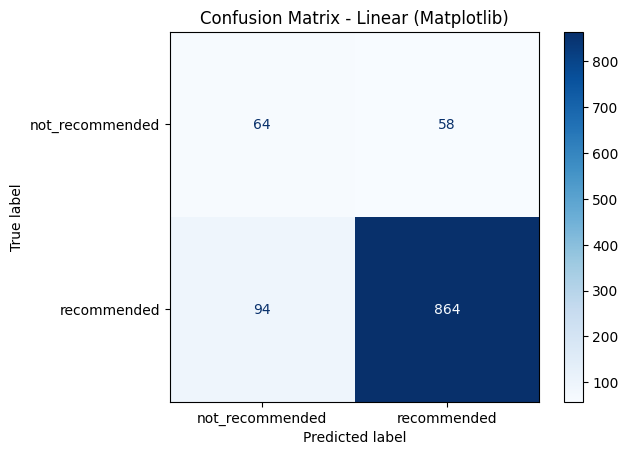

 رسم Decision Boundary دوبعدی برای Linear


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



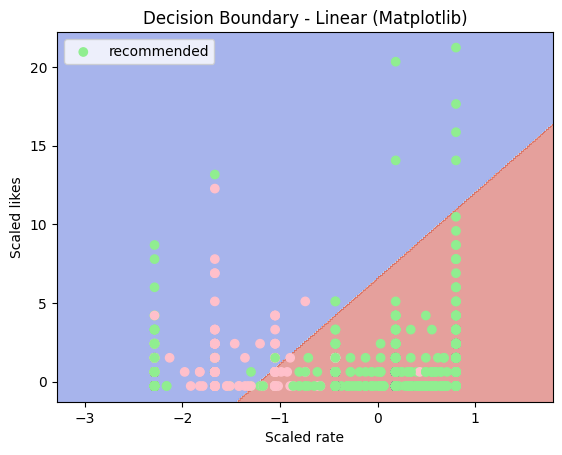


 شروع آموزش با کرنل RBF ...
Accuracy (RBF): 92.13%
 نمایش Confusion Matrix برای RBF


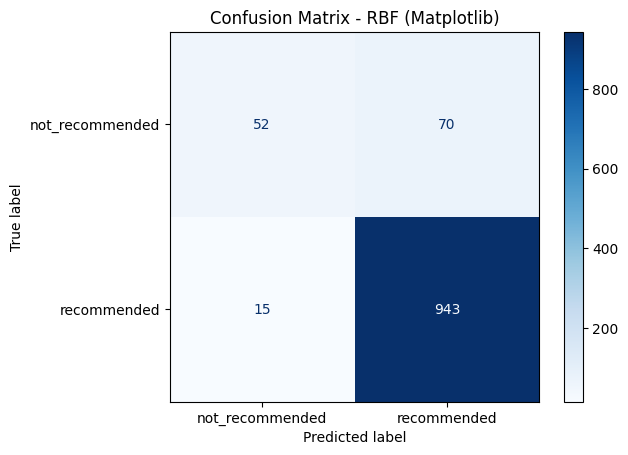

 رسم Decision Boundary دوبعدی برای RBF


/tmp/ipython-input-1144507472.py:13: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



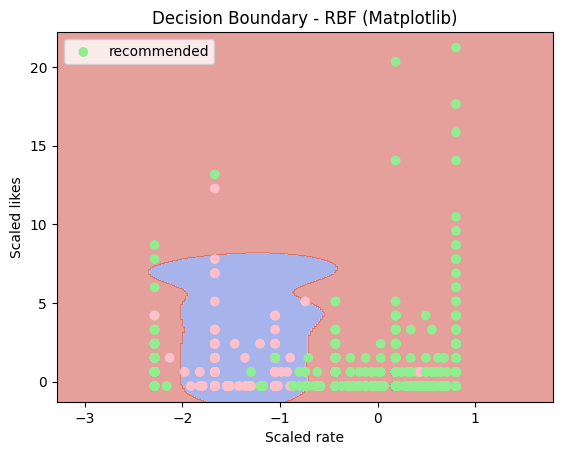


 شروع آموزش با کرنل Poly3 ...
Accuracy (Poly3): 89.63%
 نمایش Confusion Matrix برای Poly3


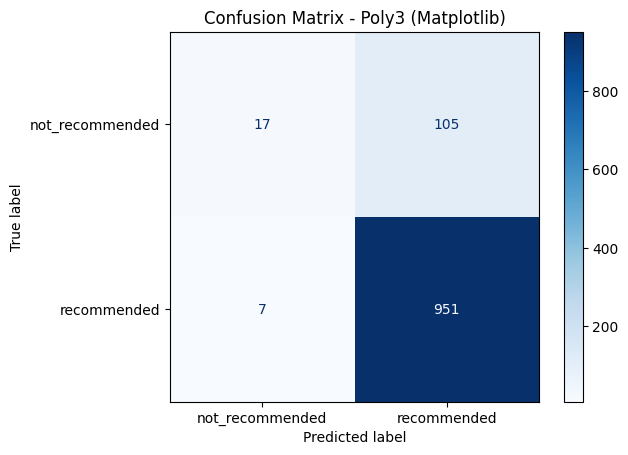

 رسم Decision Boundary دوبعدی برای Poly3


/tmp/ipython-input-1144507472.py:13: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



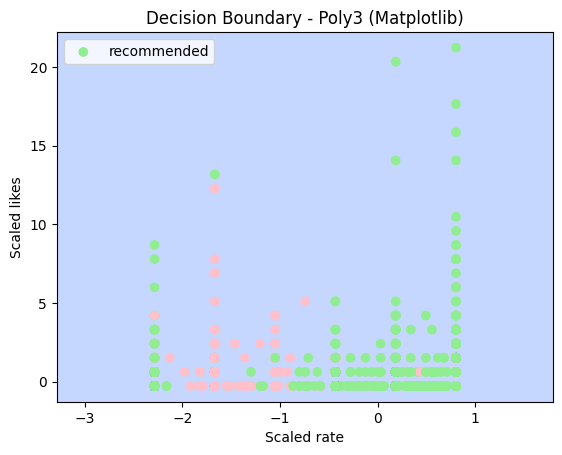


 شروع آموزش با کرنل Poly5 ...
Accuracy (Poly5): 89.26%
 نمایش Confusion Matrix برای Poly5


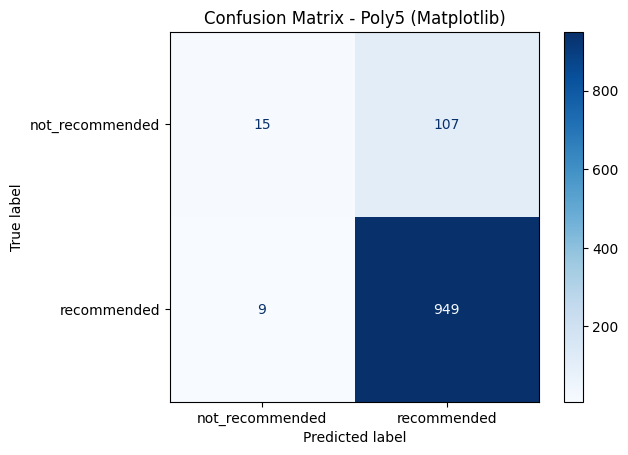

 رسم Decision Boundary دوبعدی برای Poly5


/tmp/ipython-input-1144507472.py:13: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



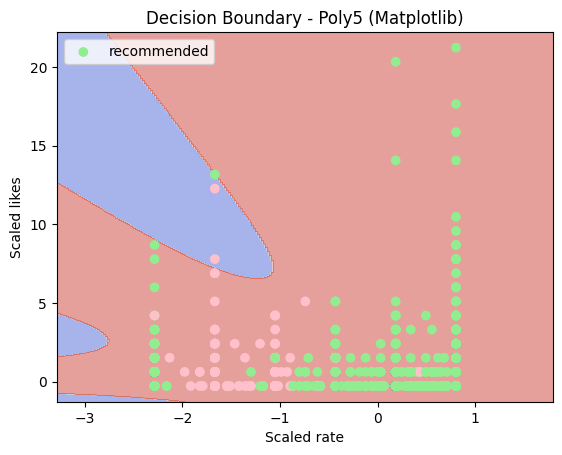


 همه کرنل‌ها پردازش شدند. نتایج در 'results' ذخیره شد.


In [115]:
# آموزش و ارزیابی
results = {}
for kernel_name, model in kernels:
    print(f'\n==============================')
    print(f' شروع آموزش با کرنل {kernel_name} ...')

    # آموزش با همه ویژگی‌ها
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy ({kernel_name}): {round(acc*100, 2)}%")
    # print(f'دقت کرنل {kernel_name}: {acc:.2f}')
    results[kernel_name] = {'y_pred': y_pred, 'model': model}


    print(f' نمایش Confusion Matrix برای {kernel_name}')
    # Confusion Matrix - Matplotlib
    plot_confusion_matrix_matplotlib(y_test, y_pred, classes, f'Confusion Matrix - {kernel_name} (Matplotlib)')

    # Confusion Matrix - Plotly
    plot_confusion_matrix_plotly(y_test, y_pred, classes, f'Confusion Matrix - {kernel_name} (Plotly)')


    print(f' رسم Decision Boundary دوبعدی برای {kernel_name}')
    # Decision Boundary با rate و likes - Matplotlib
    svm_2d = SVC(**model.get_params())
    svm_2d.fit(X_2d, y)
    plot_decision_boundary_matplotlib(X_2d, y, svm_2d, f'Decision Boundary - {kernel_name} (Matplotlib)')

    # Decision Boundary با rate و likes - Plotly
    plot_decision_boundary_plotly(X_2d, y, svm_2d, f'Decision Boundary - {kernel_name} (Plotly)')

    # Decision Boundary سه‌بعدی برای RBF
    # if kernel_name == 'RBF':
    #     print(f' رسم Decision Boundary سه‌بعدی برای {kernel_name}')
    #     X_3d = df[['rate', 'likes', 'dislikes']].values
    #     scaler_3d = StandardScaler()
    #     X_3d = scaler_3d.fit_transform(X_3d)
    #     svm_3d = SVC(kernel='rbf', C=1.0, gamma='scale')
    #     svm_3d.fit(X_3d, y)
    #     plot_decision_boundary_3d_plotly(X_3d, y, svm_3d, '3D Decision Boundary - RBF (Plotly)')

print("\n همه کرنل‌ها پردازش شدند. نتایج در 'results' ذخیره شد.")

In [ ]:
# ذخیره برای داشبورد
df.to_csv('/content/drive/MyDrive/digikala_data/processed_data_no_text.csv', index=False)
print('داده پردازش‌شده ذخیره شد.')

# تابع برای ادغام در Dash
def get_svm_results():
    return {
        'results': results,
        'X_2d': X_2d,
        'y': y,
        'label_encoder': le
    }